# Convolutional Neural Networks for Biomedical Image Analysis

**CS284A - Deep Learning**

This tutorial provides a comprehensive introduction to applying Convolutional Neural Networks (CNNs) to solve biomedical image classification problems. We'll work through a real-world medical imaging task: **Pneumonia Detection from Chest X-rays**.

## Problem Statement

Pneumonia is a serious respiratory infection that affects millions of people worldwide. Early and accurate diagnosis is crucial for effective treatment. In this tutorial, we'll build a CNN model to automatically classify chest X-ray images as either:
- **Normal**: Healthy lungs
- **Pneumonia**: Presence of pneumonia infection

This is a binary classification problem with significant clinical relevance.

## Learning Objectives

By the end of this tutorial, you will:
- Understand how CNNs extract hierarchical features from medical images
- Implement a CNN architecture from scratch using PyTorch
- Preprocess and augment medical image data appropriately
- Train and evaluate a CNN model for medical image classification
- Visualize model predictions, feature maps, and learned representations
- Understand important considerations for biomedical image analysis


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tqdm import tqdm
import kagglehub
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


PyTorch version: 2.8.0
CUDA available: False
Using device: cpu


/Users/xhx/git/CS284A/notebooks/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Understanding Convolutional Neural Networks for Medical Imaging

### Why CNNs for Medical Images?

Convolutional Neural Networks are particularly well-suited for medical image analysis because:

1. **Spatial Hierarchical Features**: CNNs learn features at multiple scales:
   - Early layers: edges, textures, basic patterns
   - Middle layers: anatomical structures (ribs, lung boundaries)
   - Deep layers: complex patterns (consolidation, opacity patterns)

2. **Translation Invariance**: Convolutions are translation-invariant, meaning the model can detect pneumonia regardless of its position in the X-ray

3. **Parameter Efficiency**: Shared weights in convolutions reduce parameters compared to fully connected networks

4. **Proven Success**: CNNs have achieved state-of-the-art performance in many medical imaging tasks

### Key CNN Components:

1. **Convolutional Layers**: Extract local features using learnable filters
2. **Pooling Layers**: Reduce spatial dimensions and increase receptive field
3. **Activation Functions**: Introduce non-linearity (ReLU, etc.)
4. **Batch Normalization**: Stabilize training and improve convergence
5. **Dropout**: Regularization to prevent overfitting
6. **Fully Connected Layers**: Final classification based on extracted features


## 2. Dataset Setup and Data Loading

For this tutorial, we'll use a chest X-ray dataset. The dataset should be organized as:
```
chest_xray/
├── train/
│   ├── NORMAL/
│   └── PNEUMONIA/
├── test/
│   ├── NORMAL/
│   └── PNEUMONIA/
└── val/
    ├── NORMAL/
    └── PNEUMONIA/
```

**Note**: If you don't have the dataset, we'll create a synthetic dataset generator for demonstration purposes, or you can download the Chest X-Ray dataset from Kaggle.

Let's first check if we have the dataset, and if not, we'll create a data loading utility that works with the standard structure.


### 2.1 Data Preprocessing and Augmentation

Medical images require careful preprocessing:
- **Normalization**: Standardize pixel values
- **Resizing**: Ensure consistent input dimensions
- **Augmentation**: Increase dataset diversity (important for medical data which is often limited)
  - Rotation, flipping (with care - medical images have orientation)
  - Brightness/contrast adjustments
  - Elastic transformations (less common for X-rays)


In [2]:
# Define data transformations
# For training: include augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to standard size
    transforms.RandomRotation(10),  # Small rotation
    transforms.RandomHorizontalFlip(0.5),  # Horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness/contrast
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                        std=[0.229, 0.224, 0.225])
])

# For validation/test: only normalization (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

print("Data transformations defined!")
print("\nTraining transforms include:")
print("  - Resize to 224x224")
print("  - Random rotation (±10 degrees)")
print("  - Random horizontal flip")
print("  - Color jitter (brightness/contrast)")
print("  - Normalization (ImageNet stats)")
print("\nValidation transforms:")
print("  - Resize to 224x224")
print("  - Normalization only")


Data transformations defined!

Training transforms include:
  - Resize to 224x224
  - Random rotation (±10 degrees)
  - Random horizontal flip
  - Color jitter (brightness/contrast)
  - Normalization (ImageNet stats)

Validation transforms:
  - Resize to 224x224
  - Normalization only


### 2.2 Downloading the Chest X-Ray Dataset

We'll download the chest X-ray dataset from Kaggle using `kagglehub`. The dataset will be automatically organized in the correct structure.


This may take a few minutes depending on your internet connection...



100%|██████████| 2.29G/2.29G [00:25<00:00, 96.3MB/s]

Extracting files...


Dataset downloaded to: /Users/xhx/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2

Found dataset structure at: /Users/xhx/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray

Dataset directories:
  Train: /Users/xhx/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train
  Test: /Users/xhx/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test
  Val: /Users/xhx/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val

Dataset loaded successfully!
Training samples: 5216
Validation samples: 16
Test samples: 624
Batch size: 32
Classes: ['Normal', 'Pneumonia']

Training set class distribution:
  Normal: 1341 samples
  Pneumonia: 3875 samples


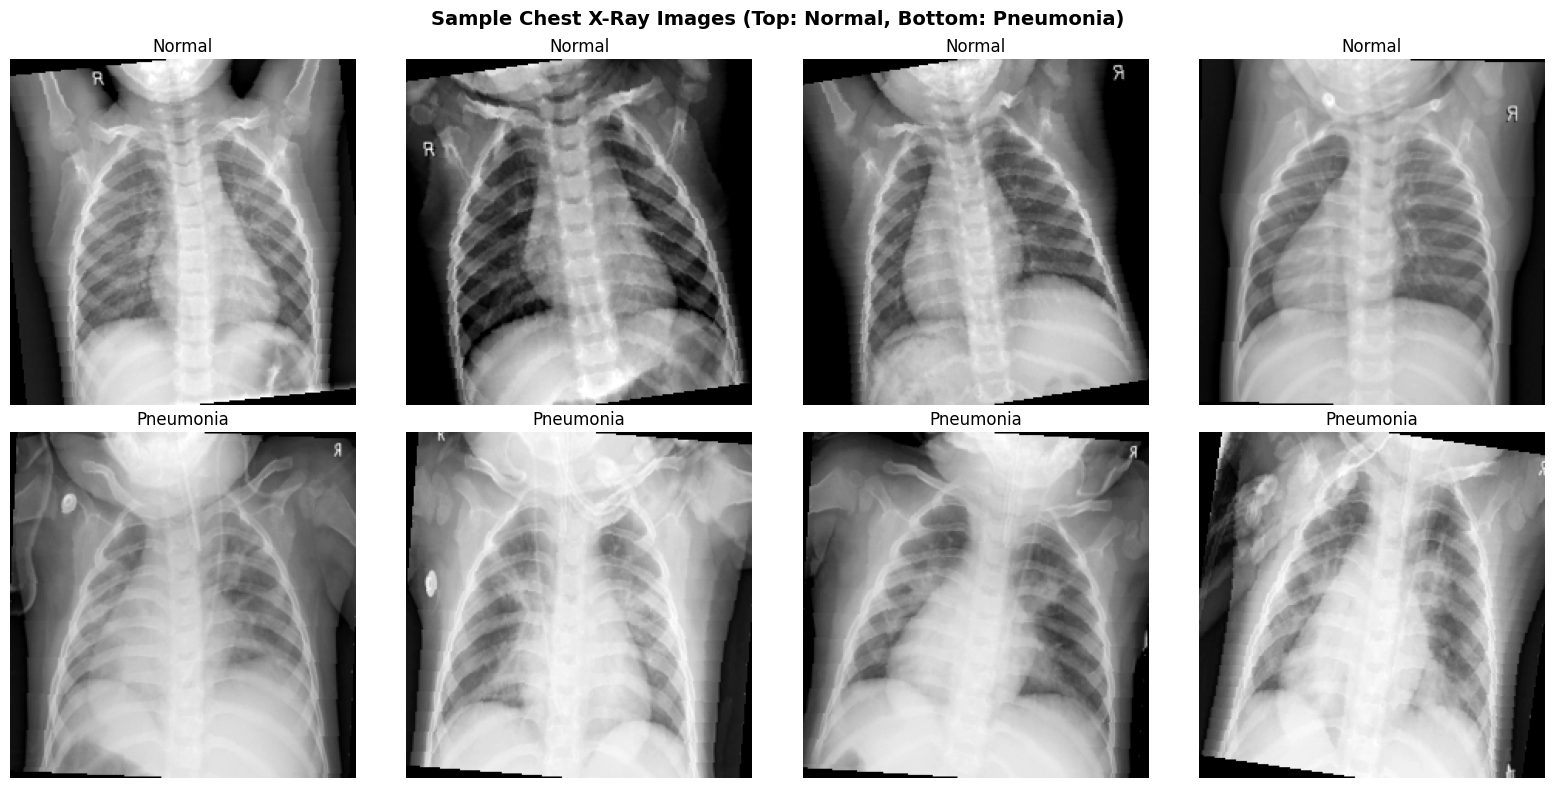

In [3]:
# Download the dataset using kagglehub
print("Downloading Chest X-Ray Pneumonia dataset from Kaggle...")
print("This may take a few minutes depending on your internet connection...\n")

# Download latest version
dataset_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print(f"Dataset downloaded to: {dataset_path}")

# The dataset structure from Kaggle might be slightly different
# Let's find the actual chest_xray directory
data_root = None

# Check common subdirectories
possible_subdirs = [
    os.path.join(dataset_path, 'chest_xray'),
    os.path.join(dataset_path, 'chest-xray-pneumonia', 'chest_xray'),
    dataset_path,  # Sometimes it's directly in the download path
]

for path in possible_subdirs:
    if os.path.exists(path):
        train_path = os.path.join(path, 'train')
        if os.path.exists(train_path):
            data_root = path
            print(f"\nFound dataset structure at: {data_root}")
            break

# If not found, search recursively
if data_root is None:
    print("\nSearching for dataset structure...")
    for root, dirs, files in os.walk(dataset_path):
        if 'train' in dirs and 'test' in dirs:
            train_path = os.path.join(root, 'train')
            if os.path.exists(os.path.join(train_path, 'NORMAL')) or os.path.exists(os.path.join(train_path, 'normal')):
                data_root = root
                print(f"Found dataset structure at: {data_root}")
                break

if data_root is None:
    print(f"\nWarning: Could not automatically find the dataset structure.")
    print(f"Please check the downloaded path: {dataset_path}")
    print(f"Expected structure:")
    print("  chest_xray/")
    print("  ├── train/")
    print("  │   ├── NORMAL/")
    print("  │   └── PNEUMONIA/")
    print("  ├── test/")
    print("  │   ├── NORMAL/")
    print("  │   └── PNEUMONIA/")
    print("  └── val/")
    print("      ├── NORMAL/")
    print("      └── PNEUMONIA/")
    raise FileNotFoundError(
        f"Could not find the expected dataset structure in {dataset_path}. "
        "Please check the downloaded files and update data_root manually."
    )

# Load datasets using ImageFolder
train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')
val_dir = os.path.join(data_root, 'val')

print(f"\nDataset directories:")
print(f"  Train: {train_dir}")
print(f"  Test: {test_dir}")
print(f"  Val: {val_dir}")

# Check if validation directory exists, if not, we'll split from train
if not os.path.exists(val_dir):
    print("Validation directory not found. Will split training data for validation.")
    use_val_split = True
else:
    use_val_split = False

# Load training dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)

# Load test dataset
test_dataset = datasets.ImageFolder(test_dir, transform=val_transform)

# Load or create validation dataset
if use_val_split:
    # Split training data into train and validation (80/20)
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
    # Note: We need to apply transforms separately, so we'll recreate
    full_train = datasets.ImageFolder(train_dir, transform=None)
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_indices, val_indices = random_split(range(len(full_train)), [train_size, val_size])
    
    # Create subset datasets with proper transforms
    class SubsetDataset(Dataset):
        def __init__(self, dataset, indices, transform):
            self.dataset = dataset
            self.indices = list(indices)
            self.transform = transform
            # Preserve class information
            if hasattr(dataset, 'classes'):
                self.classes = dataset.classes
            if hasattr(dataset, 'targets'):
                self.targets = [dataset.targets[i] for i in self.indices]
        
        def __len__(self):
            return len(self.indices)
        
        def __getitem__(self, idx):
            img, label = self.dataset[self.indices[idx]]
            if self.transform:
                img = self.transform(img)
            return img, label
    
    train_dataset = SubsetDataset(full_train, train_indices, train_transform)
    val_dataset = SubsetDataset(full_train, val_indices, val_transform)
else:
    val_dataset = datasets.ImageFolder(val_dir, transform=val_transform)

# Get class names from the dataset
# Handle both ImageFolder and SubsetDataset
if hasattr(train_dataset, 'dataset'):
    # For SubsetDataset
    if hasattr(train_dataset.dataset, 'classes'):
        class_names_raw = train_dataset.dataset.classes
    else:
        class_names_raw = ['NORMAL', 'PNEUMONIA']
elif hasattr(train_dataset, 'classes'):
    # For ImageFolder
    class_names_raw = train_dataset.classes
else:
    class_names_raw = ['NORMAL', 'PNEUMONIA']

# Map to our naming convention
class_name_map = {'NORMAL': 'Normal', 'PNEUMONIA': 'Pneumonia'}
class_names = [class_name_map.get(name.upper(), name) for name in class_names_raw]

# Create data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nDataset loaded successfully!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Classes: {class_names}")

# Count samples per class in training set
class_counts = {}
for idx in range(min(1000, len(train_dataset))):  # Sample first 1000 to avoid long computation
    try:
        _, label = train_dataset[idx]
        class_name = class_names[label] if label < len(class_names) else f'Class_{label}'
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    except:
        continue

# If we have the full ImageFolder, get exact counts
if hasattr(train_dataset, 'dataset') and hasattr(train_dataset.dataset, 'targets'):
    # For ImageFolder with targets
    from collections import Counter
    all_labels = train_dataset.dataset.targets
    train_labels = [all_labels[i] for i in train_dataset.indices]
    label_counts = Counter(train_labels)
    class_counts = {class_names[label]: count for label, count in label_counts.items()}
elif hasattr(train_dataset, 'targets'):
    from collections import Counter
    label_counts = Counter(train_dataset.targets)
    class_counts = {class_names[label]: count for label, count in label_counts.items()}

print(f"\nTraining set class distribution:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count} samples")

# Visualize some samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Get samples from each class
normal_indices = []
pneumonia_indices = []

# Try to find samples from each class
for i in range(min(500, len(train_dataset))):  # Check first 500 samples
    try:
        img, label = train_dataset[i]
        label_name = class_names[label] if label < len(class_names) else ''
        if 'Normal' in label_name and len(normal_indices) < 4:
            normal_indices.append(i)
        elif 'Pneumonia' in label_name and len(pneumonia_indices) < 4:
            pneumonia_indices.append(i)
        if len(normal_indices) >= 4 and len(pneumonia_indices) >= 4:
            break
    except Exception as e:
        continue

# If we didn't find enough, try reverse order
if len(normal_indices) < 4 or len(pneumonia_indices) < 4:
    for i in range(len(train_dataset) - 1, max(0, len(train_dataset) - 500), -1):
        try:
            img, label = train_dataset[i]
            label_name = class_names[label] if label < len(class_names) else ''
            if 'Normal' in label_name and len(normal_indices) < 4:
                normal_indices.append(i)
            elif 'Pneumonia' in label_name and len(pneumonia_indices) < 4:
                pneumonia_indices.append(i)
            if len(normal_indices) >= 4 and len(pneumonia_indices) >= 4:
                break
        except:
            continue

# Display Normal samples
for i in range(4):
    if i < len(normal_indices):
        idx = normal_indices[i]
        img, label = train_dataset[idx]
        # Denormalize for visualization
        img_vis = img.permute(1, 2, 0).numpy()
        img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_vis = np.clip(img_vis, 0, 1)
        # Convert to grayscale for display (take mean across channels)
        img_vis = img_vis.mean(axis=2)
        axes[0, i].imshow(img_vis, cmap='gray')
        label_name = class_names[label] if label < len(class_names) else f'Class {label}'
        axes[0, i].set_title(f'{label_name}')
    else:
        axes[0, i].text(0.5, 0.5, 'No sample', ha='center', va='center')
    axes[0, i].axis('off')

# Display Pneumonia samples
for i in range(4):
    if i < len(pneumonia_indices):
        idx = pneumonia_indices[i]
        img, label = train_dataset[idx]
        img_vis = img.permute(1, 2, 0).numpy()
        img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_vis = np.clip(img_vis, 0, 1)
        img_vis = img_vis.mean(axis=2)
        axes[1, i].imshow(img_vis, cmap='gray')
        label_name = class_names[label] if label < len(class_names) else f'Class {label}'
        axes[1, i].set_title(f'{label_name}')
    else:
        axes[1, i].text(0.5, 0.5, 'No sample', ha='center', va='center')
    axes[1, i].axis('off')

plt.suptitle('Sample Chest X-Ray Images (Top: Normal, Bottom: Pneumonia)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 3. Building the CNN Architecture

We'll implement a CNN architecture inspired by VGG-style networks, but tailored for medical image classification. The architecture will have:

1. **Convolutional Blocks**: Each block contains:
   - Convolutional layers
   - Batch normalization
   - ReLU activation
   - Max pooling

2. **Feature Extraction**: Multiple convolutional blocks to extract hierarchical features

3. **Classification Head**: Fully connected layers for final classification


In [4]:
class ConvBlock(nn.Module):
    """
    A convolutional block: Conv -> BatchNorm -> ReLU -> MaxPool
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class PneumoniaCNN(nn.Module):
    """
    CNN architecture for pneumonia detection from chest X-rays.
    
    Architecture:
    - Input: 3-channel RGB images (224x224)
    - Feature extraction: 4 convolutional blocks
    - Classification: Fully connected layers
    """
    def __init__(self, num_classes=2, dropout=0.5):
        super(PneumoniaCNN, self).__init__()
        
        # Feature extraction layers
        self.features = nn.Sequential(
            # Block 1: 3 -> 32 channels
            ConvBlock(3, 32),
            # Block 2: 32 -> 64 channels
            ConvBlock(32, 64),
            # Block 3: 64 -> 128 channels
            ConvBlock(64, 128),
            # Block 4: 128 -> 256 channels
            ConvBlock(128, 256),
        )
        
        # Adaptive pooling to handle different input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
        # Register hooks for feature visualization
        self.feature_maps = {}
        self.hooks = []
    
    def forward(self, x):
        # Extract features
        x = self.features(x)
        x = self.adaptive_pool(x)
        
        # Classify
        x = self.classifier(x)
        return x
    
    def register_hooks(self):
        """Register hooks to capture intermediate feature maps."""
        def get_activation(name):
            def hook(model, input, output):
                self.feature_maps[name] = output.detach()
            return hook
        
        # Register hooks on each conv block
        for i, layer in enumerate(self.features):
            if isinstance(layer, ConvBlock):
                self.hooks.append(
                    layer.conv.register_forward_hook(get_activation(f'conv_block_{i}'))
                )
    
    def remove_hooks(self):
        """Remove all registered hooks."""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# Create model
model = PneumoniaCNN(num_classes=2, dropout=0.5).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Test forward pass
model.eval()
with torch.no_grad():
    test_input = torch.randn(1, 3, 224, 224).to(device)
    test_output = model(test_input)
    print(f"\nInput shape: {test_input.shape}")
    print(f"Output shape: {test_output.shape}")
    print(f"Output (logits): {test_output}")


Model Architecture:
PneumoniaCNN(
  (features): Sequential(
    (0): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvBlock(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [6]:
# Training hyperparameters
LEARNING_RATE = 0.001
NUM_EPOCHS = 15
WEIGHT_DECAY = 1e-4

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print("Training setup complete!")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Weight decay: {WEIGHT_DECAY}")


Training setup complete!
Learning rate: 0.001
Number of epochs: 15
Weight decay: 0.0001


### 4.1 Training and Validation Functions


In [7]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(loader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate the model."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

print("Training and validation functions defined!")


Training and validation functions defined!


## 5. Training the Model

Let's train our CNN model and track the training progress.


In [ ]:
# Training history
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Best model tracking
best_val_acc = 0.0
best_model_state = None

print("Starting training...\n")
print("=" * 60)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
    
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

print("\n" + "=" * 60)
print("Training completed!")
print(f"Best validation accuracy: {best_val_acc:.2f}%")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print("Loaded best model weights.")


Starting training...


Epoch 1/15
------------------------------------------------------------


Validating: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


Train Loss: 0.3740 | Train Acc: 84.45%
Val Loss: 2.1477 | Val Acc: 56.25%
LR: 0.001000

Epoch 2/15
------------------------------------------------------------


Validating: 100%|██████████| 1/1 [00:07<00:00,  7.27s/it]


Train Loss: 0.1873 | Train Acc: 92.39%
Val Loss: 1.2149 | Val Acc: 68.75%
LR: 0.001000

Epoch 3/15
------------------------------------------------------------


Validating: 100%|██████████| 1/1 [00:07<00:00,  7.32s/it]


Train Loss: 0.1477 | Train Acc: 94.63%
Val Loss: 1.0528 | Val Acc: 68.75%
LR: 0.001000

Epoch 4/15
------------------------------------------------------------


Training:  22%|██▏       | 36/163 [00:48<02:26,  1.15s/it]

### 5.1 Visualizing Training Progress


In [ ]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Model Evaluation

Let's evaluate the trained model on the test set and analyze its performance.


In [ ]:
# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)

print("=" * 60)
print("TEST SET EVALUATION")
print("=" * 60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Normal', 'Pneumonia']))

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Pneumonia
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall for Normal
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print(f"\nDetailed Metrics:")
print(f"Sensitivity (Recall for Pneumonia): {sensitivity:.4f}")
print(f"Specificity (Recall for Normal): {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")


### 6.1 ROC Curve

Let's compute and visualize the ROC curve to assess the model's discrimination ability.


In [ ]:
# Get predictions with probabilities for ROC curve
model.eval()
all_probs = []
all_labels_roc = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of Pneumonia class
        all_labels_roc.extend(labels.numpy())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_roc, all_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Area Under ROC Curve (AUC): {roc_auc:.4f}")


## 7. Visualizations and Model Interpretability

Understanding what the model has learned is crucial for medical applications. Let's visualize:
1. Sample predictions
2. Feature maps from different layers
3. Model attention/activation patterns


### 7.1 Visualize Sample Predictions

Let's visualize some test samples with their predictions and confidence scores.


In [ ]:
# Get a batch of test images
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)

# Get predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    probs = F.softmax(outputs, dim=1)

# Visualize predictions
num_images = min(8, len(images))
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

class_names = ['Normal', 'Pneumonia']

for i in range(num_images):
    img = images[i].cpu()
    # Denormalize for visualization
    img_vis = img.permute(1, 2, 0).numpy()
    img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_vis = np.clip(img_vis, 0, 1)
    
    true_label = labels[i].item()
    pred_label = predicted[i].item()
    confidence = probs[i][pred_label].item()
    
    axes[i].imshow(img_vis, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    axes[i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.2f})',
                      color=color, fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 7.2 Visualize Feature Maps

Let's visualize what features the CNN learns at different layers. This helps us understand what the model is "looking at" when making predictions.


In [ ]:
# Register hooks to capture feature maps
model.register_hooks()

# Get a sample image
sample_image, sample_label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to(device)

# Forward pass to capture feature maps
model.eval()
with torch.no_grad():
    _ = model(sample_image)

# Visualize feature maps from different layers
num_layers = len([l for l in model.features if isinstance(l, ConvBlock)])
fig, axes = plt.subplots(num_layers + 1, 8, figsize=(20, 3 * (num_layers + 1)))

# Original image
img_vis = sample_image[0].cpu().permute(1, 2, 0).numpy()
img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img_vis = np.clip(img_vis, 0, 1)
axes[0, 0].imshow(img_vis, cmap='gray')
axes[0, 0].set_title('Original Image', fontweight='bold')
axes[0, 0].axis('off')
for j in range(1, 8):
    axes[0, j].axis('off')

# Feature maps from each layer
layer_idx = 0
for i, layer in enumerate(model.features):
    if isinstance(layer, ConvBlock):
        if f'conv_block_{i}' in model.feature_maps:
            feature_map = model.feature_maps[f'conv_block_{i}'][0]  # First image in batch
            # Select 8 channels to visualize
            num_channels = min(8, feature_map.shape[0])
            for j in range(num_channels):
                axes[layer_idx + 1, j].imshow(feature_map[j].cpu().numpy(), cmap='viridis')
                axes[layer_idx + 1, j].set_title(f'Layer {layer_idx+1}, Ch {j}', fontsize=8)
                axes[layer_idx + 1, j].axis('off')
            for j in range(num_channels, 8):
                axes[layer_idx + 1, j].axis('off')
            layer_idx += 1

plt.suptitle('Feature Maps from Different CNN Layers', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Remove hooks
model.remove_hooks()


### 7.3 Gradient-Based Visualization (Class Activation)

Let's use gradient-based visualization to see which parts of the image the model focuses on when making predictions.


In [ ]:
def generate_gradcam(model, image, target_class=None):
    """
    Generate Grad-CAM visualization to see which regions the model focuses on.
    Simplified version using gradients from the last convolutional layer.
    """
    model.eval()
    image = image.unsqueeze(0).to(device)
    image.requires_grad = True
    
    # Forward pass
    output = model(image)
    
    # If target_class not specified, use predicted class
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    # Backward pass
    model.zero_grad()
    output[0, target_class].backward()
    
    # Get gradients from the last conv layer
    # We'll use the last conv block's output
    gradients = image.grad.data[0]
    
    # Create heatmap
    heatmap = gradients.abs().sum(dim=0).cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    return heatmap, target_class

# Generate visualizations for a few samples
num_samples = 4
fig, axes = plt.subplots(2, num_samples, figsize=(16, 8))

for i in range(num_samples):
    img, true_label = test_dataset[i]
    img_tensor = img.unsqueeze(0).to(device)
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_label = output.argmax(dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_label].item()
    
    # Generate Grad-CAM
    heatmap, _ = generate_gradcam(model, img, target_class=pred_label)
    
    # Original image
    img_vis = img.permute(1, 2, 0).numpy()
    img_vis = img_vis * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_vis = np.clip(img_vis, 0, 1)
    
    # Display original
    axes[0, i].imshow(img_vis, cmap='gray')
    axes[0, i].set_title(f'True: {class_names[true_label]}\nPred: {class_names[pred_label]} ({confidence:.2f})',
                         fontsize=10, fontweight='bold')
    axes[0, i].axis('off')
    
    # Display heatmap
    axes[1, i].imshow(img_vis, cmap='gray', alpha=0.7)
    axes[1, i].imshow(heatmap, cmap='jet', alpha=0.5)
    axes[1, i].set_title('Attention Heatmap', fontsize=10, fontweight='bold')
    axes[1, i].axis('off')

plt.suptitle('Gradient-Based Attention Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 8. Key Takeaways and Best Practices

### What We've Learned:

1. **CNN Architecture for Medical Imaging**: 
   - Convolutional blocks extract hierarchical features
   - Batch normalization stabilizes training
   - Dropout prevents overfitting

2. **Data Preprocessing**:
   - Proper normalization is crucial
   - Data augmentation increases model robustness
   - Careful augmentation (medical images have orientation)

3. **Training Considerations**:
   - Learning rate scheduling improves convergence
   - Early stopping based on validation performance
   - Class imbalance handling (important for medical data)

4. **Evaluation Metrics**:
   - Accuracy alone is insufficient for medical applications
   - Sensitivity, Specificity, Precision, F1-score are critical
   - ROC curves provide discrimination assessment

5. **Model Interpretability**:
   - Feature map visualization shows learned patterns
   - Attention visualization highlights important regions
   - Critical for clinical acceptance

### Important Considerations for Biomedical Image Analysis:

1. **Data Quality**: Medical images require expert annotation and quality control
2. **Class Imbalance**: Medical datasets often have imbalanced classes (use weighted loss, oversampling, etc.)
3. **Generalization**: Models must generalize across different hospitals, equipment, patient populations
4. **Regulatory**: Medical AI systems may require FDA approval and validation
5. **Ethics**: Bias, fairness, and explainability are crucial
6. **Clinical Integration**: Models should assist, not replace, medical professionals

### Next Steps:

- Experiment with transfer learning (pre-trained models like ResNet, DenseNet)
- Try more advanced architectures (attention mechanisms, U-Net for segmentation)
- Explore data augmentation techniques specific to medical imaging
- Implement class weighting or focal loss for imbalanced datasets
- Study domain adaptation techniques for cross-institutional generalization
- Explore ensemble methods for improved robustness


## 9. Additional Experiments and Extensions

Here are some ideas to extend this tutorial:

1. **Transfer Learning**: Use pre-trained models (ResNet, DenseNet, EfficientNet) and fine-tune
2. **Data Augmentation**: Experiment with more sophisticated augmentation (mixup, cutout, etc.)
3. **Class Imbalance**: Implement weighted loss or focal loss for imbalanced datasets
4. **Ensemble Methods**: Combine multiple models for better performance
5. **Multi-class Classification**: Extend to classify different types of pneumonia
6. **Segmentation**: Use U-Net architecture for pixel-level segmentation of affected regions
7. **Attention Mechanisms**: Add attention layers to focus on important regions
8. **Cross-validation**: Implement k-fold cross-validation for robust evaluation


In [ ]:
# Example: Transfer Learning with ResNet
# Uncomment and modify to use a pre-trained ResNet

"""
from torchvision import models

# Load pre-trained ResNet18
resnet = models.resnet18(pretrained=True)

# Freeze early layers
for param in list(resnet.parameters())[:-10]:
    param.requires_grad = False

# Replace final layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)

# Move to device
resnet = resnet.to(device)

# Train with lower learning rate for fine-tuning
optimizer_resnet = optim.Adam(resnet.fc.parameters(), lr=0.0001)
"""

print("Tutorial complete! Experiment with the suggestions above to deepen your understanding.")


---

## References and Further Reading

1. **Krizhevsky et al. (2012)**: "ImageNet Classification with Deep Convolutional Neural Networks"
2. **Rajpurkar et al. (2017)**: "CheXNet: Radiologist-Level Pneumonia Detection on Chest X-Rays with Deep Learning"
3. **Simonyan & Zisserman (2014)**: "Very Deep Convolutional Networks for Large-Scale Image Recognition"
4. **Selvaraju et al. (2017)**: "Grad-CAM: Visual Explanations from Deep Networks"

**Datasets:**
- Chest X-Ray Dataset: Available on Kaggle
- MIMIC-CXR: Large-scale chest X-ray dataset
- NIH Chest X-ray Dataset: Publicly available medical imaging dataset

---

**End of Tutorial**
